In [1]:
from pandas import Series, DataFrame
import pandas as pd
import nltk
import operator
import re,string
from patsy import dmatrices
%pylab inline
from nltk.corpus import stopwords
import re
from itertools import chain
from collections import Counter
import random
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
train_data = pd.read_csv('Train_rev1.csv')

In [3]:
train_data[:5]

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


In [4]:
# A1, top 5 parts of speech in this corpus of job descriptions
random.seed(1000) 
rows = random.sample(range(len(train_data)), 1000) 
sample = train_data['FullDescription'][rows]
print sample[:5]


190272    A Head Chef role has become available at a gol...
163951    We are currently searching for a new batch of ...
24266     PA  Educational Environment (39 weeks per annu...
86395     SW****:Financial Controller Location:N Somerse...
114528    CPCS Forklift Driver required to work on a new...
Name: FullDescription, dtype: object


In [5]:
corpus = sample.str.cat(sep=' ')
corpus = corpus.decode('utf-8')
# Converting to lower case and making sure there are only alphabetic characters, this also get rid of punctuation
corpus_words = nltk.word_tokenize(corpus.lower())
corpus_words = [word for word in corpus_words if word.isalpha()==True]

In [6]:
# take a look at the words after tokenization and removing punctuation
pos = nltk.pos_tag(corpus_words)
pos[:10]

[(u'a', 'DT'),
 (u'head', 'NN'),
 (u'chef', 'NN'),
 (u'role', 'NN'),
 (u'has', 'VBZ'),
 (u'become', 'VBN'),
 (u'available', 'JJ'),
 (u'at', 'IN'),
 (u'a', 'DT'),
 (u'golf', 'NN')]

In [7]:
# top 5 part of speech
counts = Counter(tag for word,tag in pos)
counts.most_common()[:5]

[('NN', 62405), ('JJ', 27847), ('IN', 26443), ('DT', 20720), ('NNS', 20208)]

In [8]:
# A2, Does this corpus support Zipf’s law?
# frist, calculate the frequency of words
fdist = nltk.FreqDist(corpus_words)
sorted_fdist = pd.DataFrame(sorted(fdist.items(), key=operator.itemgetter(1),reverse=True))
sorted_fdist.columns = ['word','frequency']
# since we alrady remove non-alphabetic characters(punctuation) before, we then rank the word in sorted frequency dictionary
sorted_fdist['rank'] = sorted_fdist['frequency'].rank(method='min',ascending=False)
# take most common frequenct words and plot the graph
top_100 = sorted_fdist[:100]


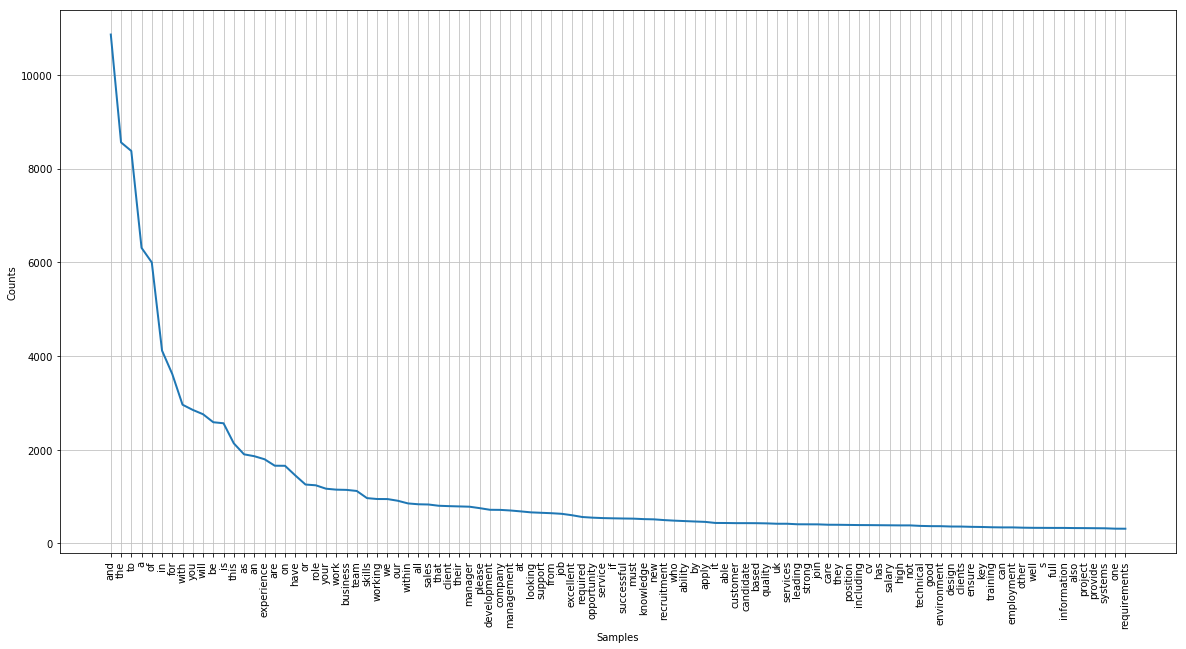

In [9]:
#plot the rank versus frequency graph
plt.figure(figsize=(20,10))
fdist.plot(100, cumulative=False)

C:\Users\zjj27\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


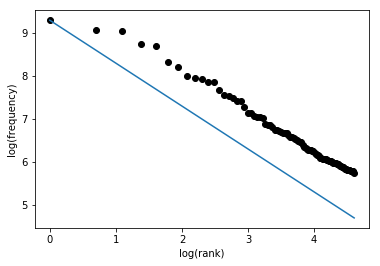

In [10]:
# Theoretical value of Zipf's law
top_100['theoretical']= [top_100["frequency"].max()/c for c in top_100['rank']]

# Plotting actuals vs theoretical
fig = plt.figure()

ax = plt.plot([math.log(c) for c in top_100['rank'].values], [math.log(c) for c in top_100['frequency']], 'ro',color='black')

ax2 = plt.plot([math.log(c) for c in top_100['rank'].values], [math.log(c) for c in top_100['theoretical']])

xlabel("log(rank)")
ylabel("log(frequency)")

In [11]:
# From the first graph, we can see that the most common 100 words does follow the Zipf's law in generally. However, from the 
# second graph, we also found out that words with higher frequency among the 100 words do not follow the law as closely.

In [12]:
# A3 remove stopword and lemmatize the corpus
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Removing stop words
filter_stopwords = [word for word in corpus_words if word not in stopwords.words('english')]

# Lemmatizing based on the POS
filtered_poi = nltk.pos_tag(filter_stopwords)

wnl = WordNetLemmatizer()
wordnet_tag ={'NN':'n','JJ':'a','VB':'v','RB':'r'}
words_lem = []
for t in filtered_poi:
    try: words_lem.append(wnl.lemmatize(t[0],wordnet_tag[t[1][:2]]))
    except: words_lem.append(wnl.lemmatize(t[0]))

# Getting most common words
fdist_2 = nltk.FreqDist(words_lem)
fdist_2.most_common(10)


[(u'work', 2167),
 (u'experience', 2014),
 (u'role', 1314),
 (u'team', 1271),
 (u'business', 1181),
 (u'client', 1152),
 (u'service', 971),
 (u'skill', 943),
 (u'manager', 890),
 (u'within', 852)]

In [13]:
# part B1
#np.percentile(sample[''], 75)


In [14]:
data = train_data.iloc[rows]


In [15]:
p=np.percentile(data['SalaryNormalized'],75)


In [16]:
def flag(s):
    if s>p:
        return 1
    else:
        return 0
    
data['Flag'] = data['SalaryNormalized'].map(flag)

C:\Users\zjj27\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [17]:
data[:5]

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Flag
190272,71741782,Head Chef Quality Focused Golf Club Restaura...,A Head Chef role has become available at a gol...,East Riding Yorkshire,East Riding,NaN,NaN,Chef Results,Hospitality & Catering Jobs,"From 22,000 to 24,000 per annum",23000,caterer.com,0
163951,71230700,"Business Travel Consultant, Hull HU****",We are currently searching for a new batch of ...,Hull,Hull,NaN,permanent,NaN,Travel Jobs,10k - 15k,12500,traveljobsearch.com,0
24266,67643933,PA To Headmistress,PA Educational Environment (39 weeks per annu...,"Brighton, East Sussex, England, East Sussex",Brighton,part_time,permanent,Solutions2Recruitment,Teaching Jobs,19500/annum,19500,cv-library.co.uk,0
86395,69090387,Financial Controller,SW****:Financial Controller Location:N Somerse...,Somerset,Somerset,NaN,permanent,Forces Recruitment Services Ltd,Accounting & Finance Jobs,20k - 30k pa + Pro rata,25000,legalprospects.com,0
114528,69750895,Telescopic Forklift Driver,CPCS Forklift Driver required to work on a new...,Bedford,Bedford,full_time,NaN,NaN,Trade & Construction Jobs,9.00 - 10.00 per hour,18240,Jobcentre Plus,0


In [18]:
# getting training and testing set and all tokens
# build a function to control if to remove stop words and apply lemmatization


train_set, test_set = data[500:], data[:500]
train = train_set[['FullDescription', 'Flag']]
test = test_set[['FullDescription', 'Flag']]

def getAllTokens(data, lemmatize, removeStopWords): 
    t = []
    stpWords = nltk.corpus.stopwords.words('english') 
    wnl = WordNetLemmatizer()
    for index, row in data.iterrows():
        jobDesc = row['FullDescription'] 
        jobDesc = jobDesc.decode('utf-8')
        
        tkns = nltk.word_tokenize(jobDesc.lower())
        tkns = [word for word in tkns if word.isalpha()==True]
        
        if removeStopWords:
            trimTkns = [w for w in tkns if w.lower() not in stpWords] 
            tkns = trimTkns[:]
        new_dict = dict() 
        for tk in tkns:
            if lemmatize:
                tr = wnl.lemmatize(tk.lower()) 
                tk = tr[:]
            new_dict[tk.lower()] = new_dict.get(tk.lower(), 0) + 1 
        t.append((new_dict, data['Flag'][index]))
    return t


In [19]:
# get the feature train data and apply the build in Naive Bayes method on train data to get the classifier
# Then apply classifier on train data to get the accuracy on test data
train_feature = getAllTokens(train, False, False)
test_feature = getAllTokens(test, False, False)
classifier = nltk.NaiveBayesClassifier.train(train_feature)
print(nltk.classify.accuracy(classifier, test_feature))


0.606


In [20]:
# Confusion matrix
test_mod = [x[0] for x in test_feature]
predict = classifier.classify_many(test_mod)
actual = [x[1] for x in test_feature]
cm = nltk.ConfusionMatrix(actual, predict)
print (cm.pretty_format(sort_by_count=True, show_percents=True))


  |      0      1 |
--+---------------+
0 | <38.2%> 36.2% |
1 |   3.2% <22.4%>|
--+---------------+
(row = reference; col = test)



In [ ]:
# if we just remove puctuation and apply naive bayes classification method, we get a model accuracy of 60.6%

In [21]:
# Part B2, Do lemmatization to see if accuracy of Naive Bayes classification increases
# since we build a function in previous question, we just need to set lemmatize to be True
train_feature_lem = getAllTokens(train, True, False) 
test_feature_lem = getAllTokens(test, True, False) 
classifier = nltk.NaiveBayesClassifier.train(train_feature_lem) 
print(nltk.classify.accuracy(classifier, test_feature_lem))


0.598


In [ ]:
# After Lemmatization, the model accuracy drops from 60.6% to 59.8%.

In [22]:
#	Creating confusion matrix 
test_mod = [x[0] for x in test_feature_lem]
predict = classifier.classify_many(test_mod)
actual = [x[1] for x in test_feature_lem]
cm = nltk.ConfusionMatrix(actual, predict)
print (cm.pretty_format(sort_by_count=True, show_percents=True))


  |      0      1 |
--+---------------+
0 | <37.4%> 37.0% |
1 |   3.2% <22.4%>|
--+---------------+
(row = reference; col = test)



In [27]:
# Part B3, Remove stop words but do not lemmatize and compare to Part B1 and B2.

train_feature_sw = getAllTokens(train, False, True) 
test_feature_sw = getAllTokens(test, False, True) 
classifier = nltk.NaiveBayesClassifier.train(train_feature_sw) 
print(nltk.classify.accuracy(classifier, test_feature_sw))
print classifier.show_most_informative_features(10)

0.582
Most Informative Features
                 insight = 1                   1 : 0      =     14.1 : 1.0
                   might = 1                   1 : 0      =     14.1 : 1.0
                   board = 1                   1 : 0      =     12.3 : 1.0
                     iso = 1                   1 : 0      =     11.9 : 1.0
               currently = 2                   1 : 0      =     11.9 : 1.0
               demanding = 1                   1 : 0      =     11.9 : 1.0
                oriented = 1                   1 : 0      =     11.9 : 1.0
                 pricing = 1                   1 : 0      =     11.9 : 1.0
                   meets = 1                   1 : 0      =      9.8 : 1.0
              approaches = 1                   1 : 0      =      9.8 : 1.0
None


In [24]:
# After we remove the stop words, the, model accuracy drops to 58.2% and is lowest among the three. Therefore, we conclude that
# Naive Bayes classification perform the best when we just remove the puctuation and do not lemmatize and do not remove the 
# stop words from the tokens.

In [ ]:
# Part B4

In [28]:
import itertools
from nltk.collocations import BigramCollocationFinder 
from nltk.metrics import BigramAssocMeasures

# Function for getting bigrams
def bigram_word_feats(words, score_fn=BigramAssocMeasures.chi_sq, n=200): 
    bigram_finder = BigramCollocationFinder.from_words(words)
    bigrams = bigram_finder.nbest(score_fn, n)
    return dict([(ngram, True) for ngram in itertools.chain(words, bigrams)])


In [38]:
# Creating training feature set for tokens including bigram using already created training dataset in B1
train_feature_bi = []
for index, row in train.iterrows(): 
    jobDesc = row['FullDescription']
    jobDesc = jobDesc.decode('utf-8')
    tkns = nltk.word_tokenize(jobDesc)
    for tk in tkns:
        tk = tk.lower()
        tkns_final = bigram_word_feats(tkns) 
        
        new_dict = dict()
        for tk in tkns_final:
            new_dict[tk] = new_dict.get(tk, 0) + 1            
        train_feature_bi.append((new_dict, train['Flag'][index]))

In [33]:
# Creating test feature set for tokens including bigram using already created test dataset in B1 
test_feature_bi = []
for index, row in test.iterrows(): 
    jobDesc = row['FullDescription'] 
    jobDesc = jobDesc.decode('utf-8')
    tkns = nltk.word_tokenize(jobDesc) 
    for tk in tkns:
        tk = tk.lower()
        tkns_final = bigram_word_feats(tkns) 
    new_dict = dict()
    for tk in tkns_final:
        new_dict[tk] = new_dict.get(tk, 0) + 1 
        test_feature_bi.append((new_dict, test['Flag'][index])) 


In [39]:
classifier_bi = nltk.NaiveBayesClassifier.train(train_feature_bi)
print(nltk.classify.accuracy(classifier_bi, test_feature_bi))


0.747575542907


In [ ]:
# After we add the part-of-speech bigrams, the model accuracy increases to 74.76% and it is also the highest model accuracy
# we have so far.